In [10]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline # for plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
# data_path = 'data/financial_data/USD_INR.csv'
data_path = 'data/bike_data/hour.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# Showing the data file csv or comma separated value
data[:10]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


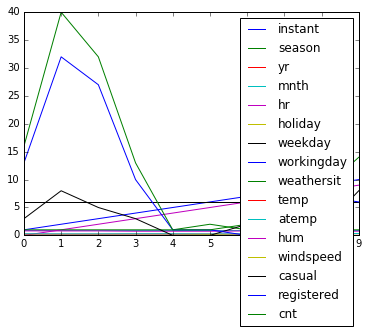

In [11]:
# # Plotting the smartwatch data before scaling/batch normalization
# data[:10000]['Price'].plot()
data[: 10].plot()
plt.legend()
plt.show()

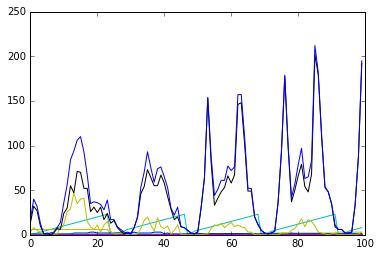

In [12]:
data_array = np.array(data)
data_array.shape, data_array.dtype
data_main = np.array(data_array[:, 2:], dtype=float)
data_main.shape, data_main.dtype

plt.plot(data_main[:100])
plt.show()

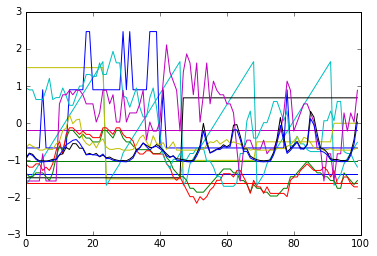

(-2.0933188371550222e-17,
 0.99999999999999978,
 0.99999999999999967,
 (17379, 15),
 dtype('float64'))

In [13]:
mean = np.mean(data_main, axis=0)
std = np.std(data_main, axis=0)
std.shape, mean.shape, std.dtype, mean.dtype

data_norm = (data_main - mean) / std
plt.plot(data_norm[:100])
plt.show()
data_norm.mean(), data_norm.std(), data_norm.var(), data_norm.shape, data_norm.dtype

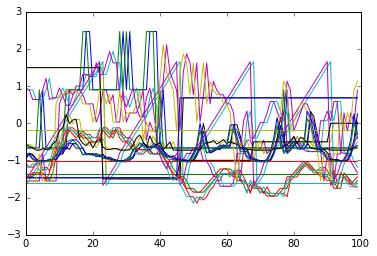

In [14]:
train_data = data_norm[:16000] # the last dim/variable/feature
test_data = data_norm[16000:] # the last dim/variable/feature
train_data.shape, test_data.shape
X_train = train_data[0:15999]
Y_train = train_data[1:16000]
X_train.shape, Y_train.shape

plt.plot(X_train[:100])
plt.plot(Y_train[:100])
plt.show()

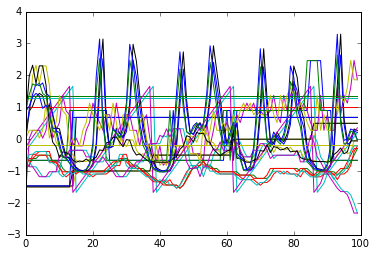

In [15]:
X_valid = test_data[0:1378] 
Y_valid = test_data[1:1379]
X_valid.shape, Y_valid.shape
plt.plot(X_valid[:100])
plt.plot(Y_valid[:100])
plt.show()

In [16]:
def get_im2col_indices(X_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    # Input shape
    N, C, H, W = X_shape
    
    # Kernel shape
    # field_height, field_width = kernel_shape
    field_C = C
    
    # X_txn, t = H, n = W
    p_H = padding
    p_W = padding
    
    # Output shape
    assert (H + (2 * p_H) - field_height) % stride == 0
    assert (W + (2 * p_W) - field_width) % stride == 0
    out_height = int(((H + (2 * p_H) - field_height) / stride) + 1)
    out_width = int(((W + (2 * p_W) - field_width) / stride) + 1)
    out_C = 1 # the output channel/ depth
#     print('out_height, out_width', out_height, out_width)

    # Row, Height, i
    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, field_C)
    i1 = np.repeat(np.arange(out_height), out_width)
    i1 = np.tile(i1, out_C)
    i1 *= stride
    
    # Column, Width, j
    j0 = np.tile(np.arange(field_width), field_height * field_C)
    j1 = np.tile(np.arange(out_width), out_height * out_C)
    j1 *= stride
    
    # Channel, Depth, K
    k0 = np.repeat(np.arange(field_C), field_height * field_width) #.reshape(-1, 1) # out_C = 1
    k1 = np.repeat(np.arange(out_C), out_height * out_width) #.reshape(-1, 1) # out_C = 1
    k1 *= stride
    
    # Indices: i, j, k index
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)
    k = k0.reshape(-1, 1) + k1.reshape(1, -1)
    
#     print('i.shape, j.shape, k.shape', i.shape, j.shape, k.shape)
    return (k.astype(int), i.astype(int), j.astype(int))

def im2col_indices(X, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    # X_txn, t = H, n = W
    p_H = padding
    p_W = padding
    X_padded = np.pad(X, ((0, 0), (0, 0), (p_H, p_H), (p_W, p_W)), mode='constant') # X_NxCxHxW

    k, i, j = get_im2col_indices(X.shape, field_height, field_width, padding, stride)

    X_col = X_padded[:, k, i, j] # X_col_txkxn
    
    N, C, H, W = X.shape
    
    # field_height, field_width = kernel_shape
    field_C = C # x.shape[1]
    kernel_size = field_C * field_height * field_width
    
    X_col = X_col.transpose(1, 2, 0).reshape(kernel_size, -1)
    
    return X_col

def col2im_indices(X_col, X_shape, field_height=3, field_width=3, padding=1, stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = X_shape
    p_H = padding
    p_W = padding
    H_padded, W_padded = H + (2 * p_H), W + (2 * p_W)
    X_padded = np.zeros((N, C, H_padded, W_padded), dtype=X_col.dtype)
    
    k, i, j = get_im2col_indices(X_shape, field_height, field_width, padding, stride)

    # field_height, field_width = kernel_shape
    field_C = C # x.shape[1]
    kernel_size = field_C * field_height * field_width

    X_col = X_col.reshape(kernel_size, -1, N).transpose(2, 0, 1) # N, K, H * W
#     print('X_col.shape', X_col.shape)
    
    np.add.at(X_padded, (slice(None), k, i, j), X_col) # slice(None)== ':'
    
#     print('X_padded.shape', X_padded.shape)
    if padding > 0:
        X_padded = X_padded[:, :, padding:-padding, padding:-padding]
#     print('X_padded.shape', X_padded.shape)
    
    return X_padded

def conv_forward(X, W, b, stride=1, padding=0):
    cache = W, b, stride, padding
    
    # Input X
    n_x, d_x, h_x, w_x = X.shape
    
    # Kernel W
    n_filter, d_filter, h_filter, w_filter = W.shape
    
    # Output
    p_H = padding
    p_W = padding
    h_out = ((h_x + (2 * p_H) - h_filter) / stride) + 1
    w_out = ((w_x + (2 * p_W) - w_filter) / stride) + 1

    if not h_out.is_integer() or not w_out.is_integer():
        raise Exception('Invalid output dimension!')

    h_out, w_out = int(h_out), int(w_out)

    X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
    W_col = W.reshape(n_filter, -1)

    out = (W_col @ X_col) + b
    out = out.reshape(n_filter, h_out, w_out, n_x).transpose(3, 0, 1, 2)
    cache = (X, W, b, stride, padding, X_col)

    return out, cache

def conv_backward(dout, cache):
    X, W, b, stride, padding, X_col = cache
    n_filter, d_filter, h_filter, w_filter = W.shape
    
#     print('dout.shape', dout.shape)

    db = np.sum(dout, axis=(0, 2, 3))
    db = db.reshape(n_filter, -1)

    dout = dout.transpose(1, 2, 3, 0).reshape(n_filter, -1)
    dW = dout @ X_col.T
    dW = dW.reshape(W.shape)

    W = W.reshape(n_filter, -1)
    dX_col = W.T @ dout
    dX = col2im_indices(dX_col, X.shape, h_filter, w_filter, padding=padding, stride=stride)

    return dX, dW, db

# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    # scale = 255. - mean # std or sqrt(var), 255 == 2**8 or 8 bit grayscale
    # return (X_train - mean)/ scale, (X_val - mean)/ scale, (X_test - mean) / scale
    return X_train - mean, X_val - mean, X_test - mean

def selu_forward(X):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
    cache = X
    return out, cache

def selu_backward(dout, cache):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    X = cache
    dX_pos = dout.copy()
    dX_pos[X<0] = 0
    dX_neg = dout.copy()
    dX_neg[X>0] = 0
    dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
    return dX

# p_dropout = keep_prob in this case. 
# Is this true in other cases as well? Yes.
def selu_dropout_forward(h, q):
    '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    alpha_p = -scale * alpha
    mask = np.random.binomial(1, q, size=h.shape)
    dropped = (mask * h) + ((1 - mask) * alpha_p)
    a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
    b = -a * (1 - q) * alpha_p
    out = (a * dropped) + b
    cache = (a, mask)
    return out, cache

def selu_dropout_backward(dout, cache):
    a, mask = cache
    d_dropped = dout * a
    dh = d_dropped * mask
    return dh

In [17]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class CRNN:

    def __init__(self, D, H, L, p_dropout, conv_size): #, lam):
        self.L = L # number of layers or depth
        self.H = H # the state hidden units and kernel depth
        self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[], 'valid':[]}
        self.model = [] # model params: w and b
        self.conv_size = conv_size
#         self.lam = lam
        
        # Model parameters: weights and biases
        # Input layer of Conv - X_txn: t== height, n == D
        # No padding in this layer
        # kernel_NCHW
        kN = H # number of kernel units/ neurons  
        kC = 1 # kernel channels/depth == input channel == X_NxCxHxW == this is C == stack of images or minibatches
        kH = conv_size # kernel height = time
        kW = D # kernel with = input width = dim/ features/ channels
        kernel_size = kC * kH * kW # number of synapses of the kernels
        m = dict(
            W1=np.random.randn(kN, kC, kH, kW) / np.sqrt(kC * kH * kW / 2.), # W_NCHW in this fashion
            b1=np.zeros((kN, 1))
        )
        self.model.append(m) # self.model[0][L]
        
        # Hidden layers of Conv-bn-relu-dropout
        # No padding also in this layer since H & W are both 1
        kN = H # number of kernel units/ neurons  
        kC = H # kernel channels/depth == input channel
        kH = 1 # kernel height
        kW = 1 # kernel with = input width
        m = dict(
            W2=np.random.randn(kN, kC, kH, kW) / np.sqrt(kC * kH * kW / 2.), # W_NCHW in this fashion
            b2=np.zeros((kN, 1))
        )
        m_L = [] # for all layers: L
        for _ in range(self.L):
            m_L.append(m)
        self.model.append(m_L) # self.model[1][L]
        
        # RNN instead of FFNN as FC net for the last layer 
        # which is mapping the function or function approximation.
        #         # Output layer of FC to output: FFNN -  can be replace by RNN
        #         m = dict(
        #             W3=np.random.randn(H, D) / np.sqrt(H/ 2.), # W_NCHW in this fashion
        #             b3=np.zeros((1, D))
        #         )
        #         self.model.append(m) # self.model[2][L]
        # Model params
        # H for both hidden layers of state/ h 
        # H as the flattened layer input to the FC layer
        Z = H + H
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model.append(m) # self.model[2][L]
        
    def initial_state(self):
        return np.zeros((1, self.H))

    def cnn_forward(self, X, train):
        
        # Preprocessing: reshaping X_txn to X_1x1xtxn 
        X = X.reshape(1, 1, *X.shape) # X_1x1xtxn
#         print('X.shape', X.shape)
        
        # 1st layer - Input layer: X
        X, X_conv_cache = conv_forward(X=X, W=self.model[0]['W1'], b=self.model[0]['b1'])
        X_cache = X_conv_cache
#         print('X.shape', X.shape)

        # 2nd layers - Hidden layers: h
        h_cache = []
        for layer in range(self.L):
            h, h_conv_cache = conv_forward(X=X, W=self.model[1][layer]['W2'], b=self.model[1][layer]['b2'])
            h, h_nl_cache = selu_forward(X=h)
            if train:
                h, h_do_cache = selu_dropout_forward(h=h, q=self.p_dropout)
                cache = (h_conv_cache, h_nl_cache, h_do_cache)
            else:
                cache = () # NOT used in testing! Only used for backward pass.
            h_cache.append(cache)
#         print('h.shape', h.shape)
  
        # This goes to RNN
        #         # 3rd layer - Output layer: y
        #         y = h.reshape([X.shape[0], -1]) # flattening
        # #         print('y.shape', y.shape)        
        #         y, y_fc_cache = l.fc_forward(X=y, W=self.model[2]['W3'], b=self.model[2]['b3']) # y_1xn
        #        y_cache = X, y_fc_cache
        y_cache = h.shape
        y = h.reshape(1, -1) # y_1xn
#         print('y.shape', y.shape)        
        cache = (X_cache, h_cache, y_cache)
        
        return y, cache

    def rnn_forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, 
                 y_cache)

        return y, h, cache
    
    def rnn_backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad
        
    def cnn_backward(self, dy, cache):
        X_cache, h_cache, y_cache = cache

        # dy is coming from rnn_backward
        #         # 3rd layer: Ouput layer y
        #         X, y_fc_cache = y_cache
        #         dy, dw3, db3 = l.fc_backward(dout=dy, cache=y_fc_cache)
        #         print('dy.shape', dy.shape)
        #         dy = dy.reshape([-1, *X.shape[1:4]])
        #         print('dy.shape', dy.shape)
#         print('dy.shape', dy.shape)
        h_shape = y_cache
        dy = dy.reshape(h_shape)
#         print('dy.shape', dy.shape)
        
        # 2nd layers: Hidden layers h
        grad2 = []
        for layer in reversed(range(self.L)):
            # if train: There is no backward in testing/prediction
            h_conv_cache, h_nl_cache, h_do_cache = h_cache[layer]
            dy = selu_dropout_backward(dout=dy, cache=h_do_cache)
            dh = selu_backward(dout=dy, cache=h_nl_cache)
            dh, dw2, db2 = conv_backward(dout=dh, cache=h_conv_cache)
            grad2.append(dict(W2=dw2, b2=db2))
            
        # 1st layer: Input layer X
        X_conv_cache = X_cache
        dX, dw1, db1 = conv_backward(dout=dh, cache=X_conv_cache)
        grad1 = dict(W1=dw1, b1=db1)

        # grad for GD
        grads = []
        grads.append(grad1)
        grads.append(grad2)
        
        return dX, grads
    
    # This is for convolution.
    def get_minibatch_conv(self, X, y, minibatch_size, shuffle):
        minibatches = []

        for i in range(0, X.shape[0] - minibatch_size + 1, 1):
            X_mini = X[i:(i + minibatch_size)] # X_txn
            y_mini = y[(i + minibatch_size - 1) :(i + minibatch_size)] # y_1xn
            minibatches.append((X_mini, y_mini))

        return minibatches
    
    def train_forward(self, XY_minibatch, h):
        y_pred, y_train, cnn_caches, rnn_caches, do_caches = [], [], [], [], []
        
        # Extracting the minibatches
        X_mini, y_mini = XY_minibatch
        minibatches = self.get_minibatch_conv(X_mini, y_mini, self.conv_size, shuffle=False) # seq data needs no shuffle

        # Conv minibatches inside the minibatches
        # for X in X_train:
        for idx in range(len(minibatches)):
            X_mini, Y_mini = minibatches[idx]
            y, cnn_cache = self.cnn_forward(X_mini, train=True) # self.model[0] and [1]
            X = y.copy() # passed the output of previous layer to the next layer
            y, h, rnn_cache = self.rnn_forward(X, h, self.model[2])
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            cnn_caches.append(cnn_cache)
            rnn_caches.append(rnn_cache)
            do_caches.append(do_cache)
            y_pred.append(y)
            y_train.append(Y_mini)
        
        # Convert from py.list to np.array
        y_pred = np.array(y_pred, dtype=float).reshape(len(y_pred), -1) # ys_txn instead of ys_tx1xn
        y_train = np.array(y_train, dtype=float).reshape(len(y_train), -1) # ys_txn instead of ys_tx1xn
        
        caches = (cnn_caches, rnn_caches, do_caches)
        ys = (y_pred, y_train)
        return ys, caches
    
    def loss_function(self, y_pred, y_train): # , alpha alpha: learning rate
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
#             loss += l2_regression_reg(model=self.model[2], y_pred=y, y_train=Y, lam=self.lam)
            loss += l2_regression(y_pred=y, y_train=Y)
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        cnn_caches, rnn_caches, do_caches = caches
        
        # Conv 1st layer
        grads1 = {key: np.zeros_like(val) for key, val in self.model[0].items()}
        
        # Conv 2nd layer
        grads2 = []
        for _ in range(self.L):
            grads2.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})

        # 3rd layer: RNN for FC net 
        dh = np.zeros((1, self.H)) 
        grad3 = {key: np.zeros_like(val) for key, val in self.model[2].items()}
        grads3 = {key: np.zeros_like(val) for key, val in self.model[2].items()}

        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dy = l.dropout_backward(dy, do_caches[t])
            
            dX, dh, grad3 = self.rnn_backward(dy, dh, rnn_caches[t])
            for key in grad3.keys():
                grads3[key] += grad3[key]

            dy = dX.copy()
            dX, grad = self.cnn_backward(dy, cnn_caches[t])
            for layer in range(self.L):
                for key in grad[1][layer].keys(): # 2nd layer
                    grads2[layer][key] += grad[1][layer][key]

            for key in grad[0].keys(): # 1st layer
                grads1[key] += grad[0][key]
                    
        grads = []
        grads.append(grads1)
        grads.append(grads2)
        grads.append(grads3)
                
        return dX, grads

    def test(self, X_seed, size, h):
        ys = []
        
        for _ in range(size):
            y, _ = self.cnn_forward(X_seed, train=False) # y_1xn, X_txn
            X = y.copy() # pass it to the next layer for RNN
            y, h, _ = self.rnn_forward(X, h, self.model[2]) # y_1xn, X_txn
#             print('y.shape, X.shape', y.shape, X.shape)
            X = np.row_stack((X_seed, y)) # X_(t+1)xn
#             print('X.shape', X.shape)
            X_seed = X[1:].copy()
#             print('X.shape', X.shape)
            ys.append(y) # ys_tx1xn
            
        y_pred = np.array(ys, dtype=float).reshape(size, -1) # ys_txn
#         print('y_pred.shape', y_pred.shape)
        return y_pred
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        num_mb = X.shape[0]// minibatch_size
        for i in range(num_mb):
            X_mini = X[(i * minibatch_size): ((i + 1) * minibatch_size)]
            y_mini = X[(i * minibatch_size): ((i + 1) * minibatch_size)]
            # y_mini = y[(((i + 1) * minibatch_size) -1) : ((i + 1) * minibatch_size)] # y_1xn
            minibatches.append((X_mini, y_mini))

        return minibatches
    
    def adam(self, train_set, valid_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_valid, y_valid = valid_set

        # Momentum variables
        # Input: CNN
        M, R = [], []
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden: CNN
        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)
        
        # RNN in this case as FC net
        # Output: FC or FFNN
        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Learning decay
        beta1 = .9
        beta2 = .99
        smooth_loss = 1.
        state = nn.initial_state()

        # Extracting the minibatches for training
        minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=False) # seq data needs no shuffle

        # Validation data and size
        size = X_valid.shape[0] # y_txn
        X_seed = X_valid[:self.conv_size]

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches for rnn
            for idx in range(len(minibatches)):
                
                # Train the model
                # X_mini, y_mini = minibatches[idx]
                ys, caches = nn.train_forward(minibatches[idx], state)
                y_pred, y_train = ys
                loss, dys = nn.loss_function(y_pred=y_pred, y_train=y_train) #, alpha=alpha
                _, grads = nn.train_backward(dys, caches)
                nn.losses['train'].append(loss)
                smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
                nn.losses['smooth train'].append(smooth_loss)

                # Update the model: input layer - CNN
                for key in grads[0].keys():
                    M[0][key] = l.exp_running_avg(M[0][key], grads[0][key], beta1)
                    R[0][key] = l.exp_running_avg(R[0][key], grads[0][key]**2, beta2)
                    m_k_hat = M[0][key] / (1. - (beta1**iter))
                    r_k_hat = R[0][key] / (1. - (beta2**iter))
                    self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

                # Update the model: hidden layers -- CNN
                for layer in range(self.L):
                    for key in grads[1][layer].keys():
                        M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grads[1][layer][key], beta1)
                        R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grads[1][layer][key]**2, beta2)
                        m_k_hat = M[1][layer][key] / (1. - (beta1**iter))
                        r_k_hat = R[1][layer][key] / (1. - (beta2**iter))
                        self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)
                        
                # Update the model: output layer - RNN
                for key in grads[2].keys():
                    M[2][key] = l.exp_running_avg(M[2][key], grads[2][key], beta1)
                    R[2][key] = l.exp_running_avg(R[2][key], grads[2][key]**2, beta2)
                    m_k_hat = M[2][key] / (1. - (beta1**iter))
                    r_k_hat = R[2][key] / (1. - (beta2**iter))
                    self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

                # Validate the model
                y_pred = self.test(X_seed, size=size, h=state)
#                 print('y_pred.shape, y_val.shape', y_pred.shape, y_valid.shape)
                valid_loss, _ = self.loss_function(y_pred, y_valid) 
                self.losses['valid'].append(valid_loss)

            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss: {:.4f}, valid loss: {:.4f}'.format(iter, loss, valid_loss))

In [18]:
# Hyper-parameters
n_iter = 10 # number of epochs
alpha = 1e-4 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
num_layers = 1 # depth 
print_after = 1 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 64 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
# num_output_units = num_input_units # number of classes in this classification problem
p_dropout = 0.95 #  layer & unit noise: keep_prob = p_dropout, q = 1-p, 0.95 or 0.90 by default, noise at the network level or layers
conv_size = mb_size// 2 # This is conv_kernel_height k_NCHW, kH is the conv_size
# lam = 1e-3

# Build the model/NN and learn it: running session.
nn = CRNN(D=num_input_units, H=num_hidden_units, p_dropout=p_dropout, L=num_layers, conv_size=conv_size) #, lam=lam)

nn.adam(train_set=(X_train, Y_train), valid_set=(X_valid, Y_valid), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-1, train loss: 12.3082, valid loss: 2098.7902
Iter-2, train loss: 12.3039, valid loss: 1442.1985
Iter-3, train loss: 12.0414, valid loss: 1418.6931
Iter-4, train loss: 12.1204, valid loss: 2111.1377
Iter-5, train loss: 12.0418, valid loss: 1341.0873
Iter-6, train loss: 12.0803, valid loss: 1069.1497
Iter-7, train loss: 11.9546, valid loss: 1196.9435
Iter-8, train loss: 11.7856, valid loss: 1429.1722
Iter-9, train loss: 11.8147, valid loss: 1215.7190
Iter-10, train loss: 12.0348, valid loss: 1218.1935


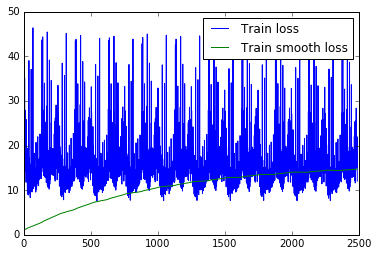

In [19]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

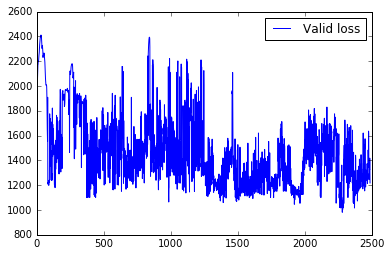

In [20]:
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

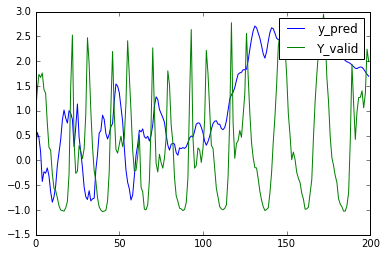

In [21]:
y_pred = nn.test(X_valid[:conv_size], size=X_valid.shape[0], h=nn.initial_state())

plt.plot(y_pred[:200, -1], label='y_pred')
plt.plot(Y_valid[:200, -1], label='Y_valid')
plt.legend()
plt.show()